###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth, C. Cooper. Based on [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

# Space & Time

## Burgers' Equation

Hi there! We have reached the final lesson of the series *Space and Time — Introduction to Finite-difference solutions of PDEs*, the second module of ["Practical Numerical Methods with Python"](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about).

We have learned about the finite-difference solution for the linear and non-linear convection equations and the diffusion equation. It's time to combine all these into one: *Burgers' equation*. The wonders of *code reuse*!

Before you continue, make sure you have completed the previous lessons of this series, it will make your life easier. You should have written your own versions of the codes in separate, clean IPython Notebooks or Python scripts.

You can read about Burgers' Equation on its [wikipedia page](http://en.wikipedia.org/wiki/Burgers'_equation).
Burgers' equation in one spatial dimension looks like this:

\begin{equation}\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial ^2u}{\partial x^2}\end{equation}

As you can see, it is a combination of non-linear convection and diffusion. It is surprising how much you learn from this neat little equation! 

We can discretize it using the methods we've already detailed in the previous notebooks of this module.  Using forward difference for time, backward difference for space and our 2nd-order method for the second derivatives yields:

\begin{equation}\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}\end{equation}

As before, once we have an initial condition, the only unknown is $u_i^{n+1}$. We will step in time as follows:

\begin{equation}u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)\end{equation}

###Initial and Boundary Conditions

To examine some interesting properties of Burgers' equation, it is helpful to use different initial and boundary conditions than we've been using for previous steps.  

The initial condition for this problem is going to be:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi(t=0) = \phi_0 &=& \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu} \bigg)
\end{eqnarray}

This has an analytical solution, given by:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}

The boundary condition will be:

\begin{equation}u(0) = u(2\pi)\end{equation}

This is called a *periodic* boundary condition. Pay attention! This will cause you a bit of headache if you don't tread carefully.

###Saving Time with SymPy


The initial condition we're using for Burgers' Equation can be a bit of a pain to evaluate by hand.  The derivative $\frac{\partial \phi}{\partial x}$ isn't too terribly difficult, but it would be easy to drop a sign or forget a factor of $x$ somewhere, so we're going to use SymPy to help us out.  

[SymPy](http://sympy.org/en/) is the symbolic math library for Python.  It has a lot of the same symbolic math functionality as Mathematica with the added benefit that we can easily translate its results back into our Python calculations (it is also free and open source). 

Start by loading the SymPy library, together with our favorite library, NumPy.

In [1]:
import numpy
import sympy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

We're also going to tell SymPy that we want all of its output to be rendered using $\LaTeX$. This will make our Notebook beautiful!

In [2]:
from sympy import init_printing
init_printing()

Start by setting up symbolic variables for the three variables in our initial condition.  It's important to recognize that once we've defined these symbolic variables, they function differently than "regular" Python variables.  

If we type `x` into a code block, we'll get an error:

In [4]:
x

NameError: name 'x' is not defined

`x` is not defined, so this shouldn't be a surprise.  Now, let's set up `x` as a *symbolic* variable:

In [5]:
x = sympy.symbols('x')

Now let's see what happens when we type `x` into a code cell:

In [6]:
x

The value of `x` is $x$.  Sympy is also referred to as a computer algebra system -- normally the value of `5*x` will return the product of `5` and whatever value `x` is pointing to.  But, if we define `x` as a symbol, then something else happens:

In [7]:
5*x

This will let us manipulate an equation with unknowns using Python!  Let's start by defining symbols for $x$, $\nu$ and $t$ and then type out the full equation for $\phi$.  We should get a nicely rendered version of our $\phi$ equation.

In [8]:
x, nu, t = sympy.symbols('x nu t')
phi = sympy.exp(-(x-4*t)**2/(4*nu*(t+1))) + \
sympy.exp(-(x-4*t-2*numpy.pi)**2/(4*nu*(t+1)))
phi

It's maybe a little small, but that looks right.  Now to evaluate our partial derivative $\frac{\partial \phi}{\partial x}$ is a trivial task.  To take a derivative with respect to $x$, we can just use:

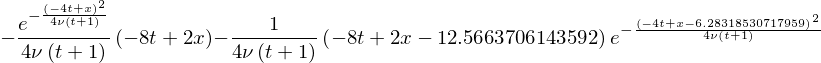

In [9]:
phiprime = phi.diff(x)
phiprime

If you want to see the unrendered version, just use the Python print command.

In [10]:
print(phiprime)

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 12.5663706143592)*exp(-(-4*t + x - 6.28318530717959)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


###Now what?


Now that we have the Pythonic version of our derivative, we can finish writing out the full initial condition equation and then translate it into a usable Python expression.  For this, we'll use the *lambdify* function, which takes a SymPy symbolic equation and turns it into a callable function.  

In [11]:
from sympy.utilities.lambdify import lambdify

u = -2*nu*(phiprime/phi)+4
print(u)

-2*nu*(-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 12.5663706143592)*exp(-(-4*t + x - 6.28318530717959)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)))/(exp(-(-4*t + x - 6.28318530717959)**2/(4*nu*(t + 1))) + exp(-(-4*t + x)**2/(4*nu*(t + 1)))) + 4


###Lambdify

To lambdify this expression into a useable function, we tell lambdify which variables to request and the function we want to plug them in to.

In [12]:
u_lamb = lambdify((t, x, nu), u)
print("The value of u at t=1, x=4, nu=3 is {}.".format(u_lamb(1,4,3)))

The value of u at t=1, x=4, nu=3 is 3.4917066420644494.


###Back to Burgers' Equation

Now that we have the initial conditions set up, we can proceed and finish setting up the problem.  We can generate the plot of the initial condition using our lambdify-ed function.

In [13]:
###variable declarations
nx = 101
nt = 100
dx = 2*numpy.pi/(nx-1)
nu = .07
sigma = .1
dt = sigma*dx**2/nu 

x = numpy.linspace(0, 2*numpy.pi, nx)
un = numpy.empty(nx)
t = 0

We have a function `u_lamb` but we need to create an array `u` with our initial conditions.  `u_lamb` will return the value for any given time $t$, position $x$ and $nu$.  We can use a `for`-loop to cycle through values of `x` to generate the `u` array.  That code would look something like this:

```Python
u = numpy.empty(nx)

for i, x0 in enumerate(x):
    u[i] = u_lamb(t, x0, nu)
```

But there's a cleaner, more beautiful way to do this -- *list comprehension*.  

We can create a list of all of the appropriate `u` values by typing

```Python
[u_lamb(t, x0, nu) for x0 in x]
```

You can see that the syntax is similar to the `for`-loop, but it only takes one line.  Using a list comprehension will create... a list.  This is different from an *array*, but converting a list to an array is trivial using `numpy.asarray()`.  

With the list comprehension in place, the three lines of code above become one:

```Python
u = numpy.asarray([u_lamb(t, x0, nu) for x0 in x])
```

In [14]:
u = numpy.asarray([u_lamb(t, x0, nu) for x0 in x])
u

array([ 4.        ,  4.06283185,  4.12566371,  4.18849556,  4.25132741,
        4.31415927,  4.37699112,  4.43982297,  4.50265482,  4.56548668,
        4.62831853,  4.69115038,  4.75398224,  4.81681409,  4.87964594,
        4.9424778 ,  5.00530965,  5.0681415 ,  5.13097336,  5.19380521,
        5.25663706,  5.31946891,  5.38230077,  5.44513262,  5.50796447,
        5.57079633,  5.63362818,  5.69646003,  5.75929189,  5.82212374,
        5.88495559,  5.94778745,  6.0106193 ,  6.07345115,  6.136283  ,
        6.19911486,  6.26194671,  6.32477856,  6.38761042,  6.45044227,
        6.51327412,  6.57610598,  6.63893783,  6.70176967,  6.76460125,
        6.82742866,  6.89018589,  6.95176632,  6.99367964,  6.72527549,
        4.        ,  1.27472451,  1.00632036,  1.04823368,  1.10981411,
        1.17257134,  1.23539875,  1.29823033,  1.36106217,  1.42389402,
        1.48672588,  1.54955773,  1.61238958,  1.67522144,  1.73805329,
        1.80088514,  1.863717  ,  1.92654885,  1.9893807 ,  2.05

Now that we have the initial conditions set up, we can plot it to see what $\phi(x,0)$ looks like:

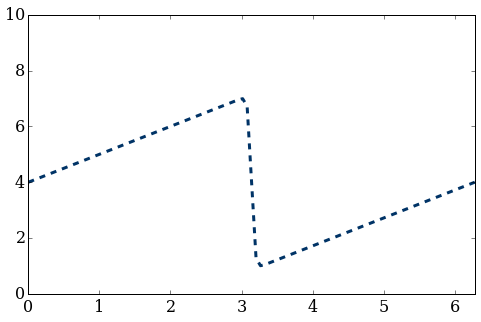

In [15]:
pyplot.figure(figsize=(8,5), dpi=100)
pyplot.plot(x,u, color='#003366', ls='--', lw=3)
pyplot.xlim([0,2*numpy.pi])
pyplot.ylim([0,10]);

This is definitely not the hat function we've been dealing with until now. We call it a "saw-tooth function".  Let's proceed forward and see what happens.  

### Periodic Boundary Conditions

We will implement Burgers' equation with *periodic* boundary conditions.  If you experiment with the linear and non-linear convection notebooks and make the simulation run longer (by increasing `nt`) you will notice that the wave will keep moving to the right until it no longer even shows up in the plot.  

With periodic boundary conditions, when a point gets to the right-hand side of the frame, it *wraps around* back to the front of the frame.  

Recall the discretization that we worked out at the beginning of this notebook:

\begin{equation}u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)\end{equation}

What does $u_{i+1}^n$ *mean* when $i$ is already at the end of the frame?

Think about this for a minute before proceeding.  



In [16]:
for n in range(nt):
    un = u.copy()
    
    u[1:-1] = un[1:-1] - un[1:-1] * dt/dx * (un[1:-1] - un[:-2]) + nu*dt/dx**2*\
                    (un[2:] - 2*un[1:-1] + un[:-2])

    u[0] = un[0] - un[0] * dt/dx * (un[0] - un[-1]) + nu*dt/dx**2*\
                (un[1] - 2*un[0] + un[-1])
    u[-1] = un[-1] - un[-1] * dt/dx * (un[-1] - un[-2]) + nu*dt/dx**2*\
                (un[0]- 2*un[-1] + un[-2])
        
    u_analytical = numpy.asarray([u_lamb(nt*dt, xi, nu) for xi in x])

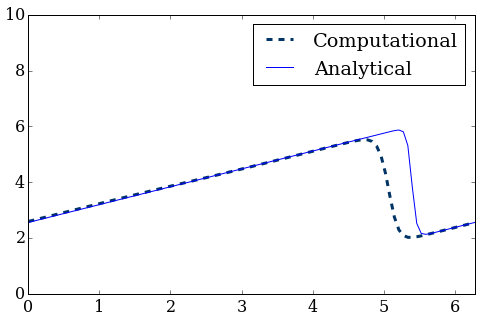

In [17]:
pyplot.figure(figsize=(8,5), dpi=100)
pyplot.plot(x,u, color='#003366', ls='--', lw=3, label='Computational')
pyplot.plot(x, u_analytical, label='Analytical')
pyplot.xlim([0,2*numpy.pi])
pyplot.ylim([0,10])
pyplot.legend();

In [18]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

In [19]:
u = numpy.asarray([u_lamb(t, x0, nu) for x0 in x])


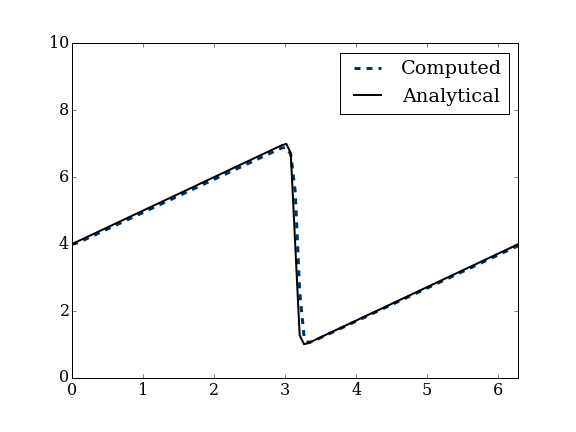
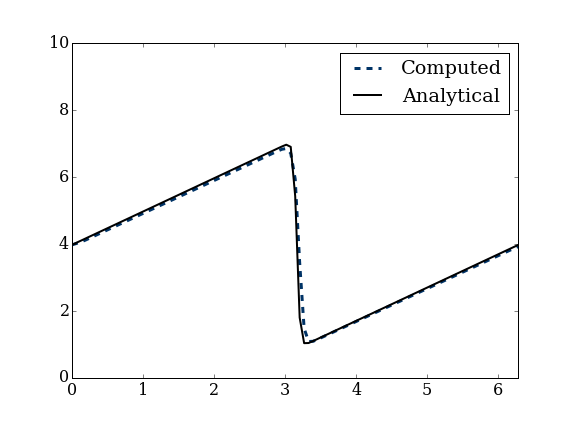
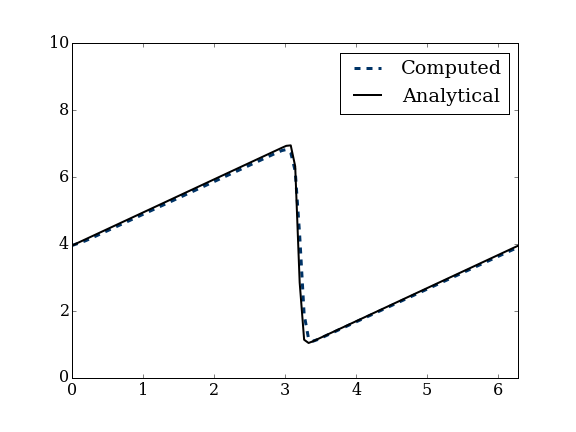
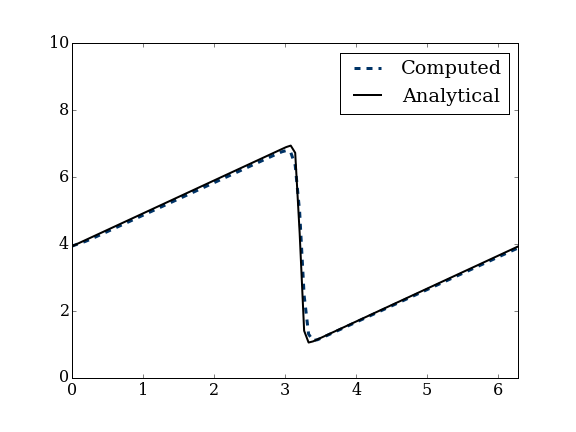
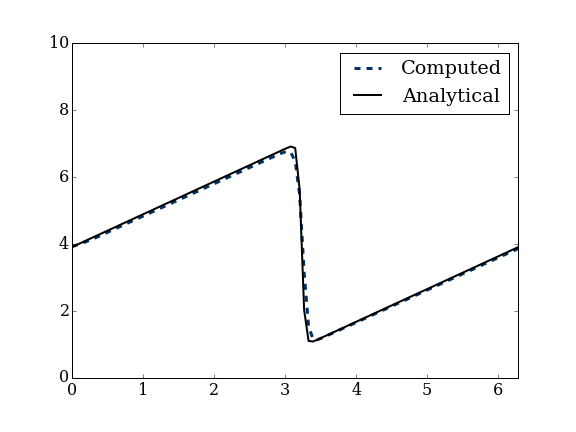
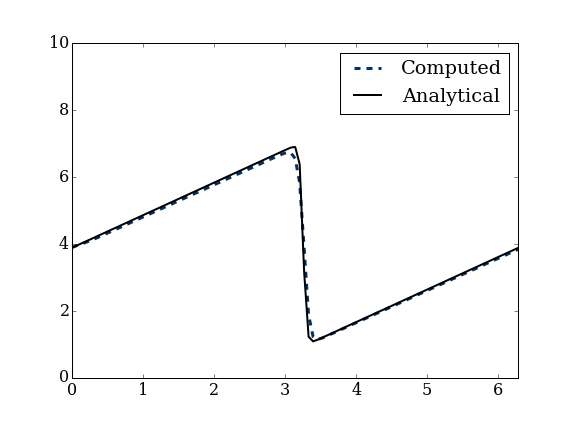
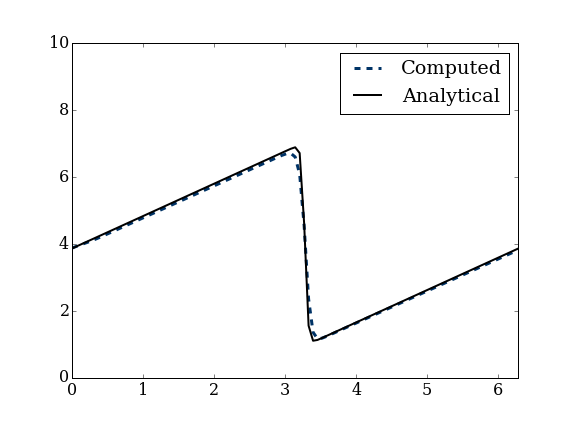
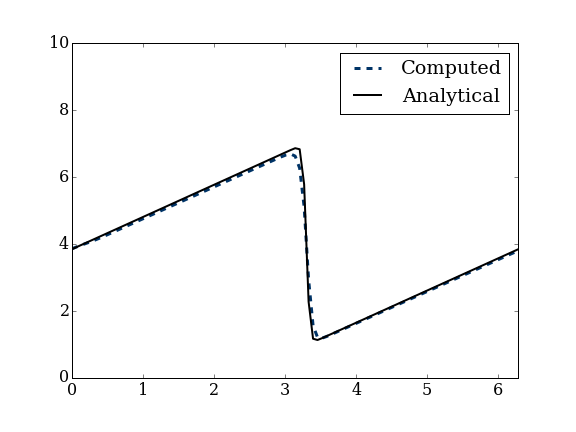
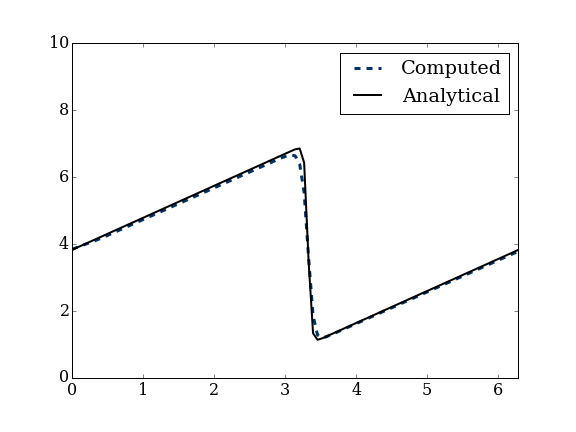
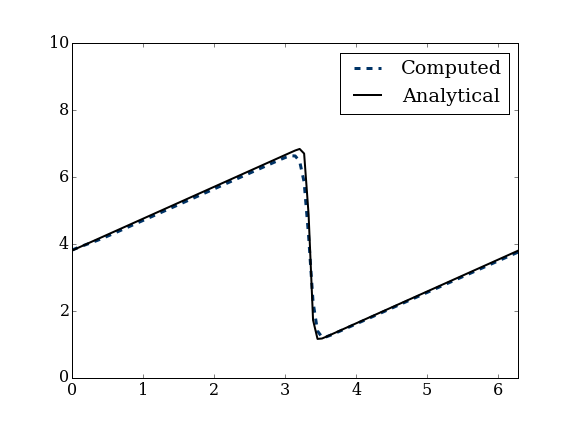
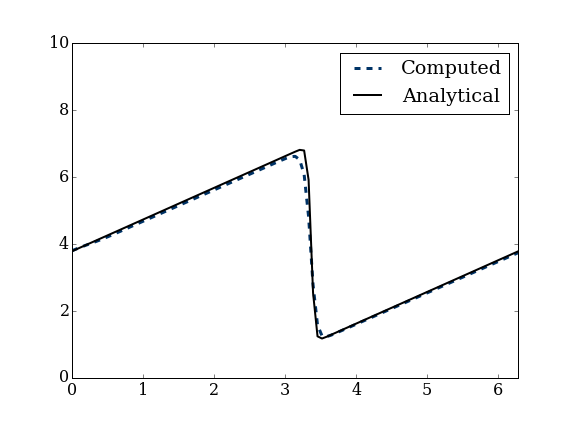
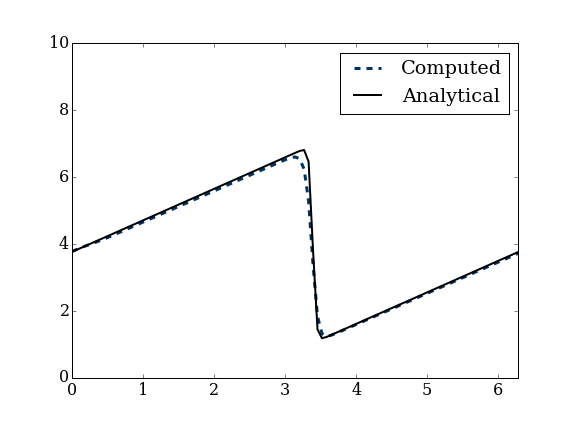
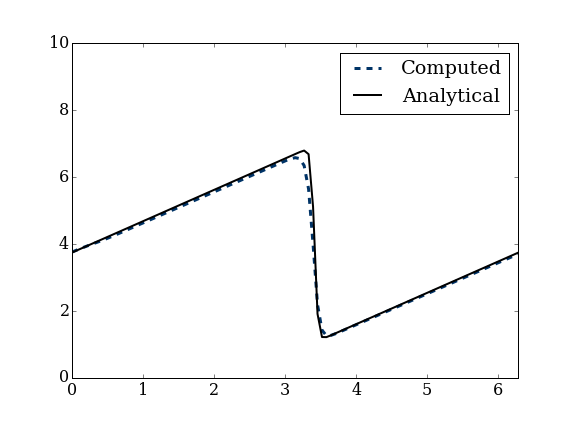
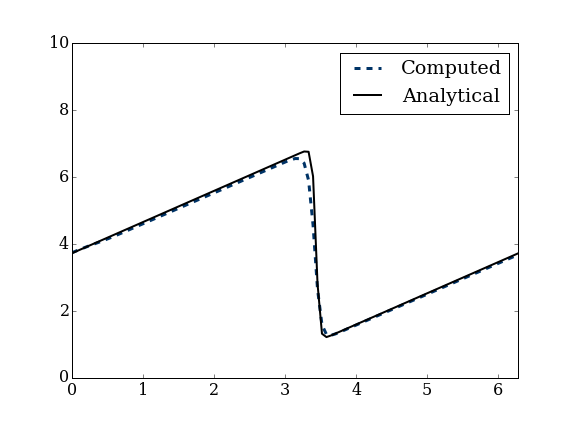
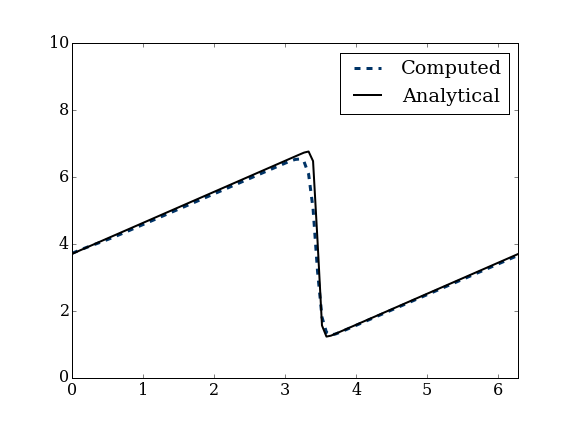
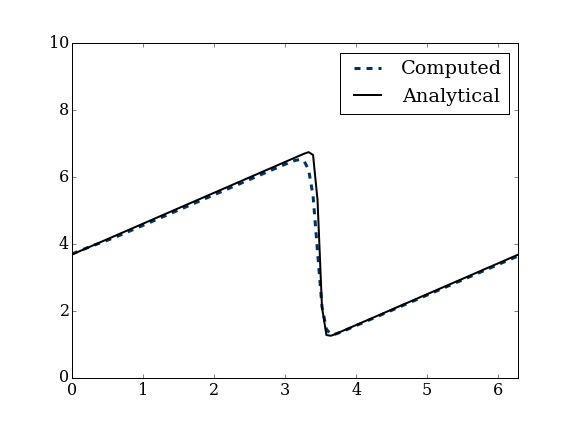
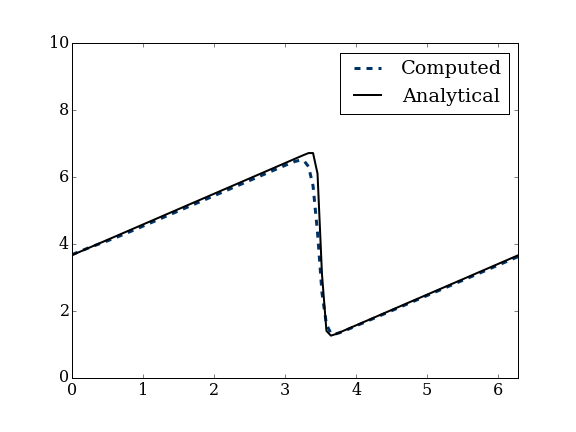
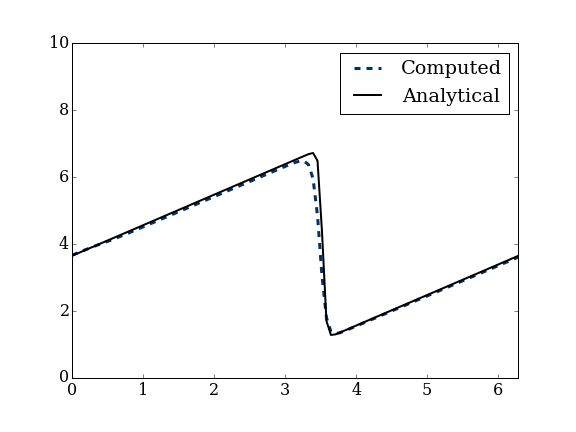
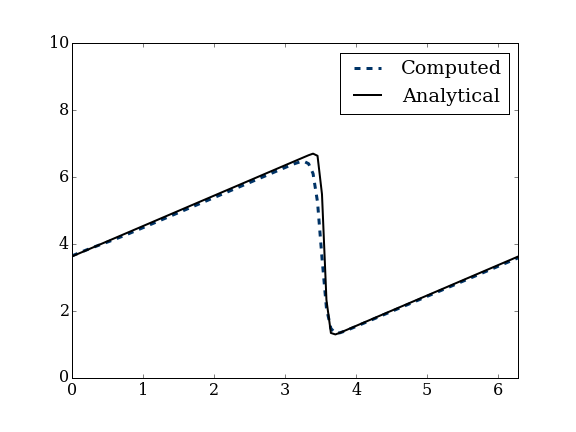
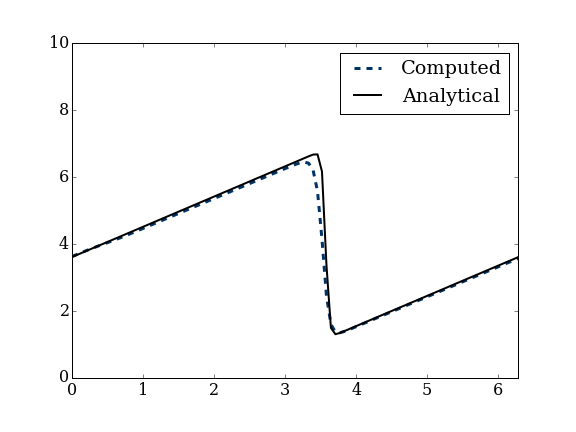
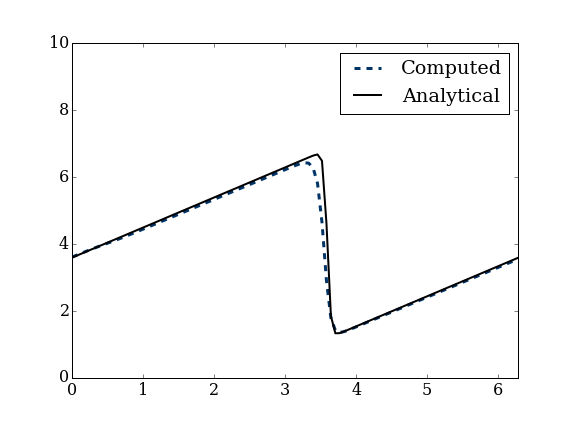
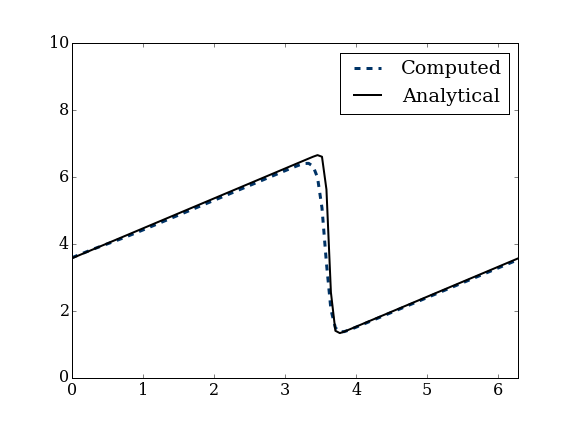
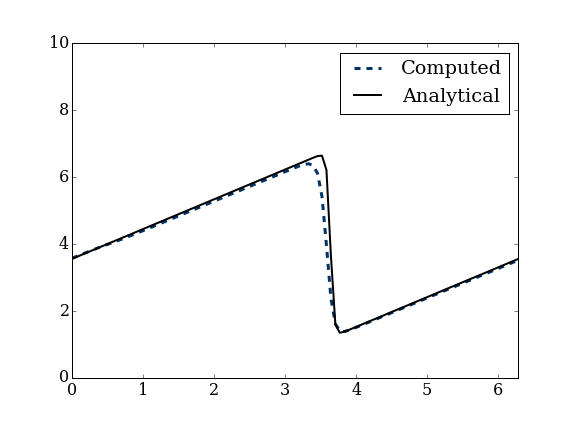
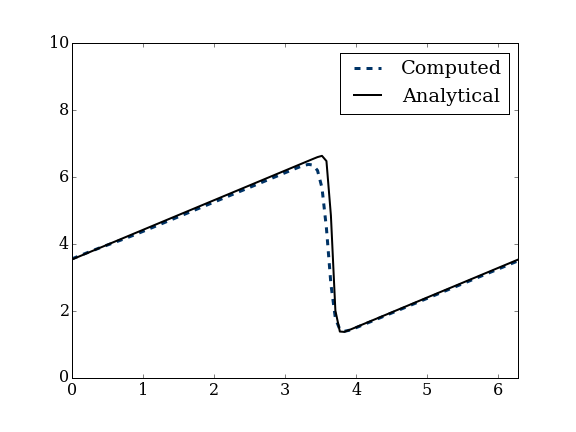
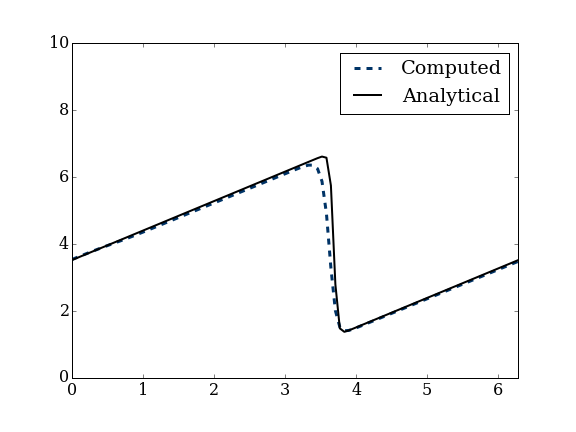
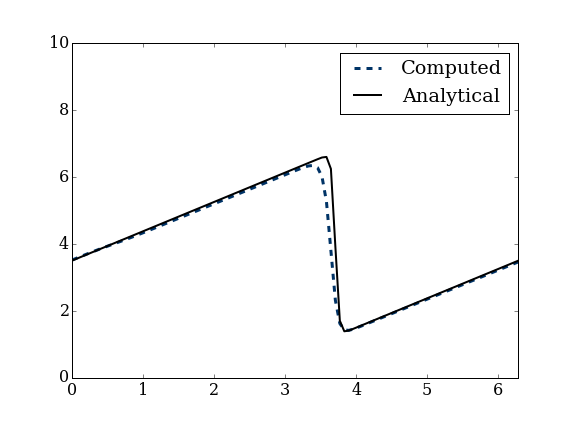
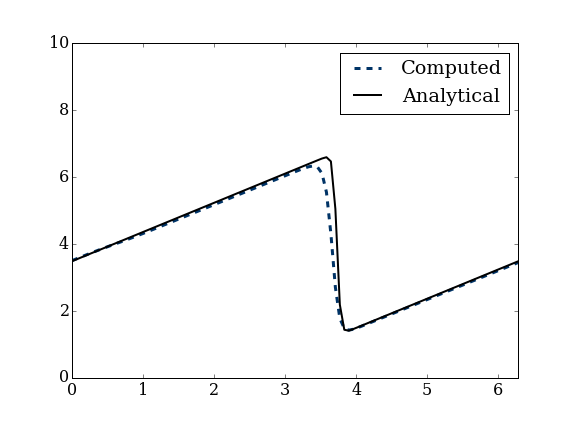
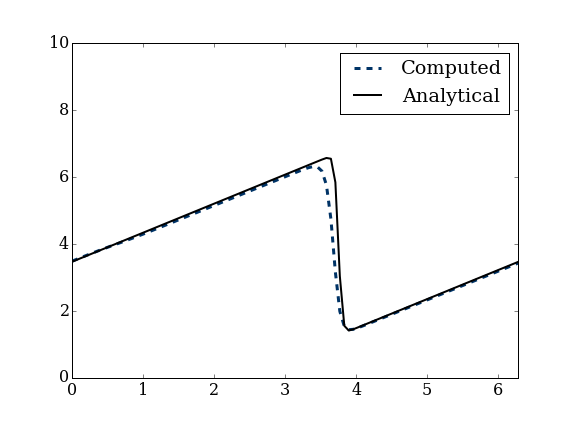
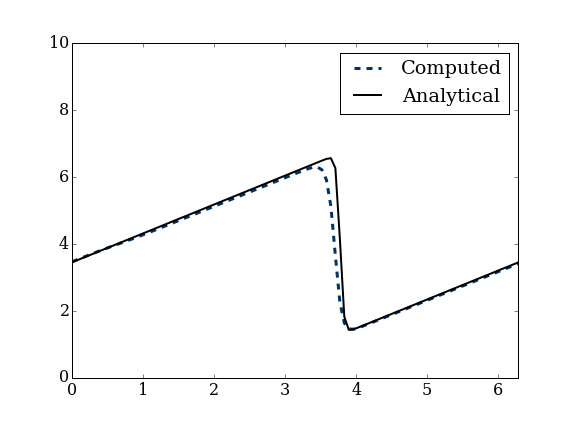
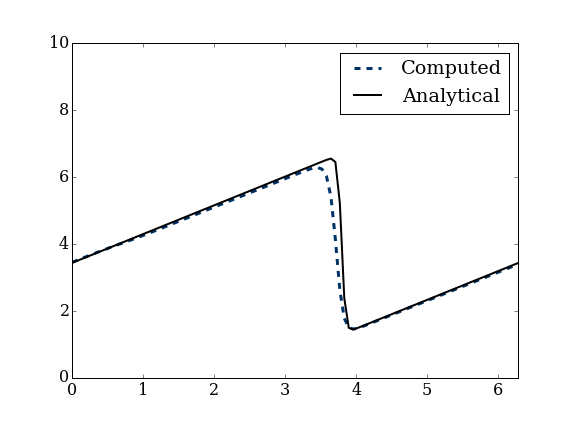
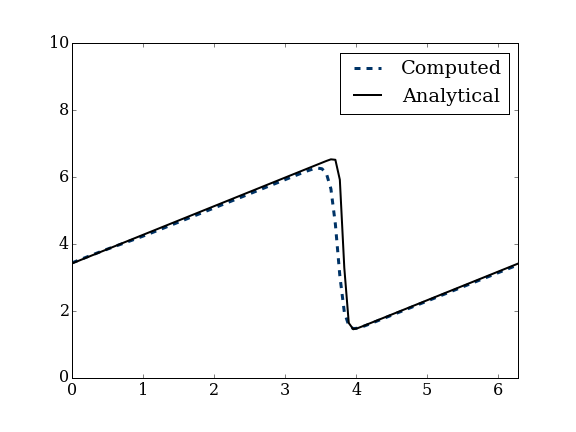
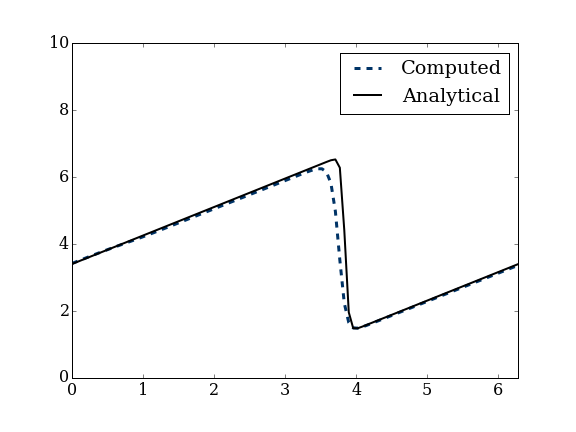
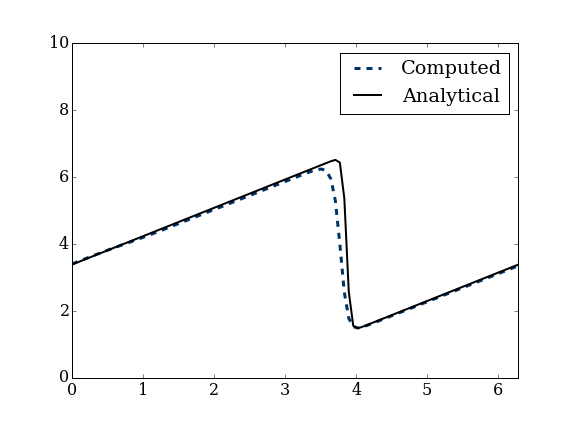
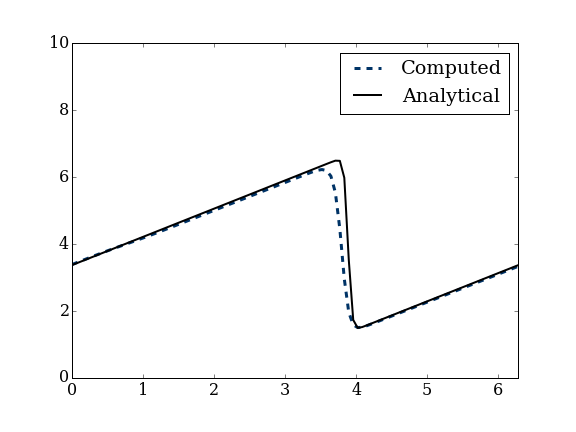
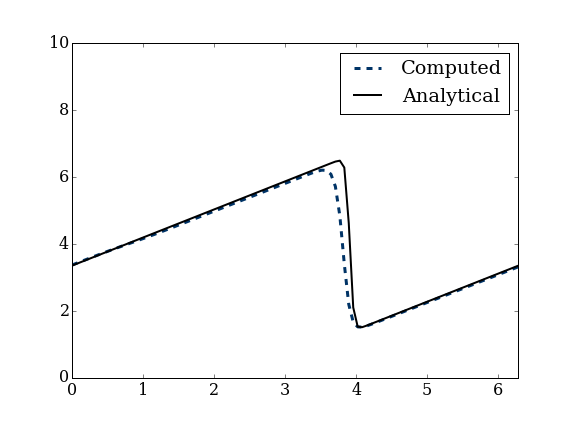
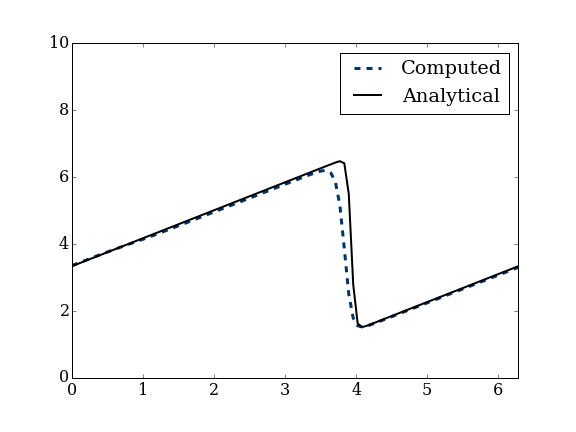
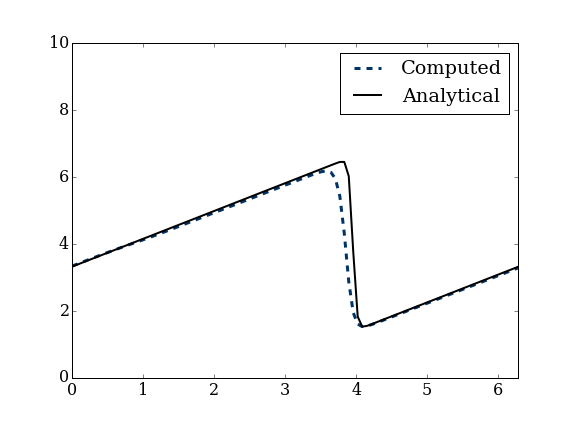
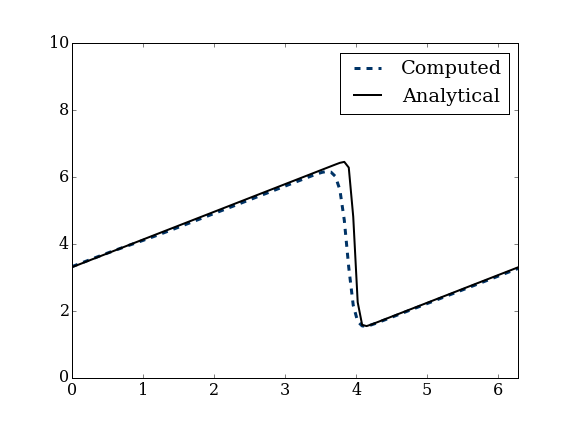
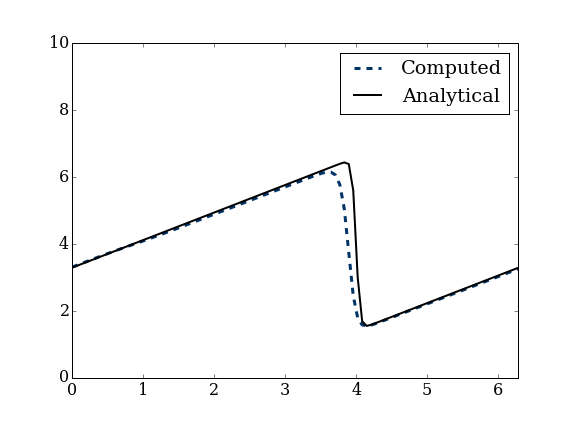
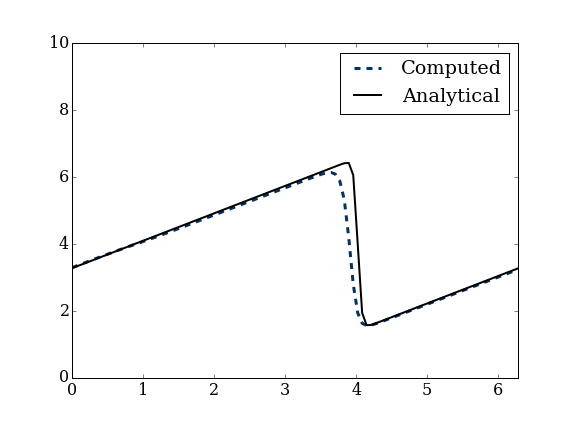
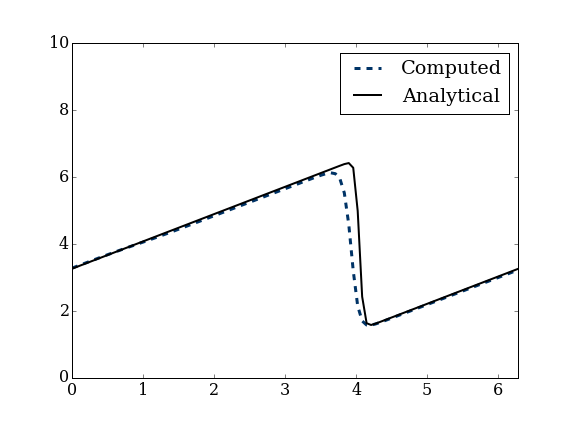
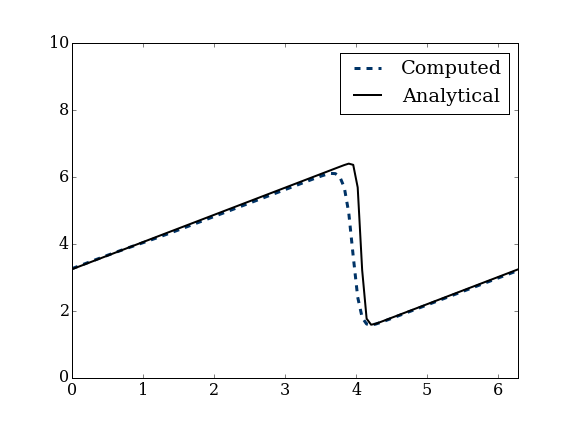
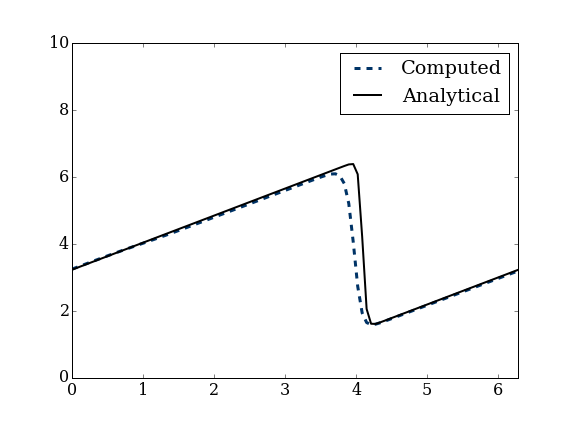
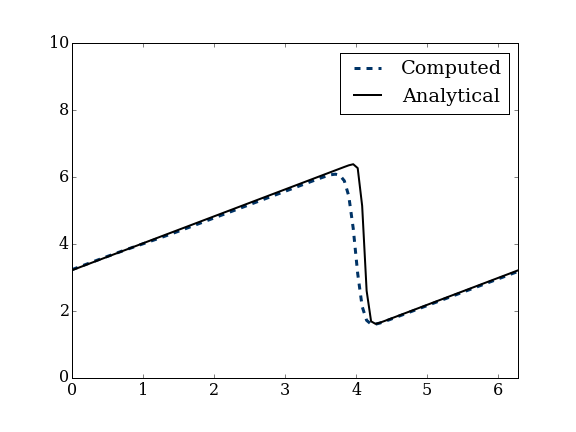
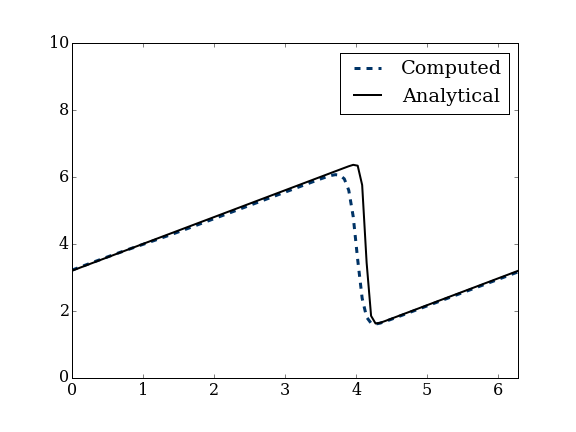
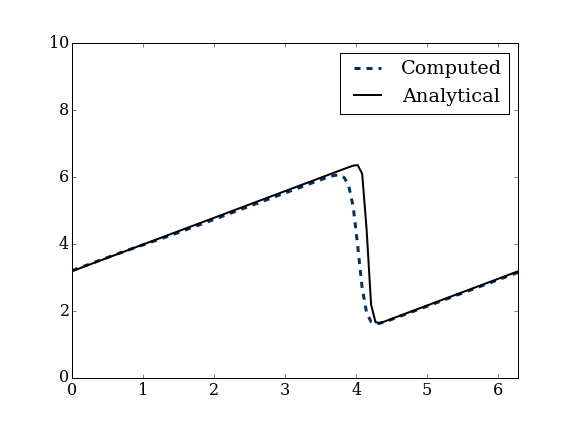
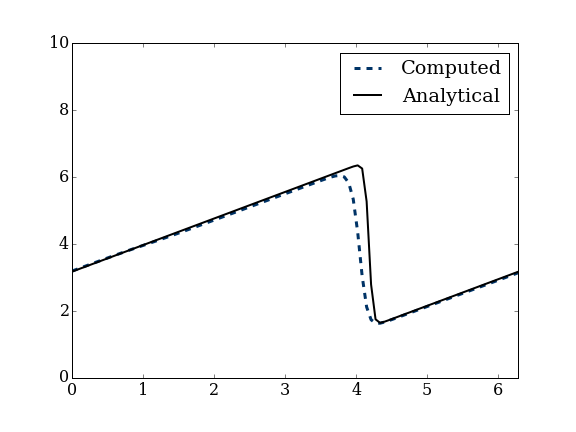
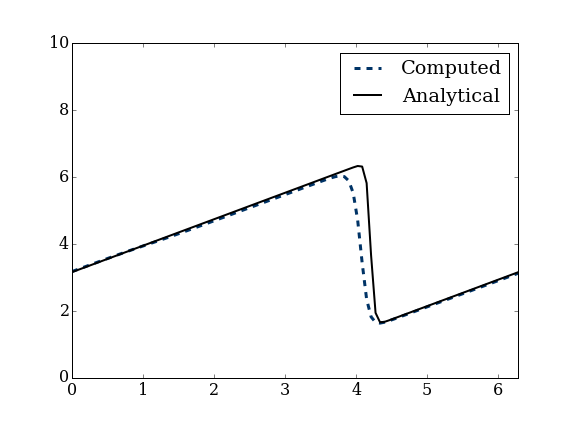
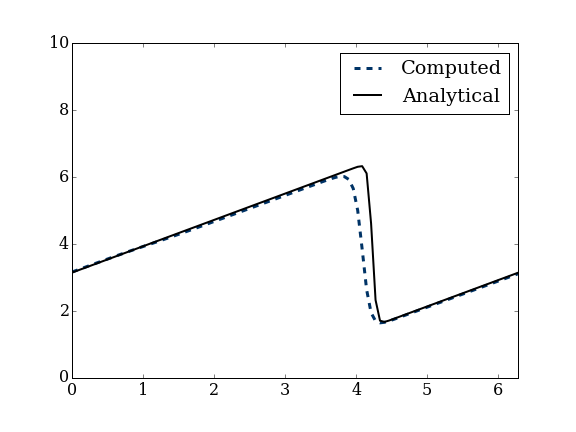
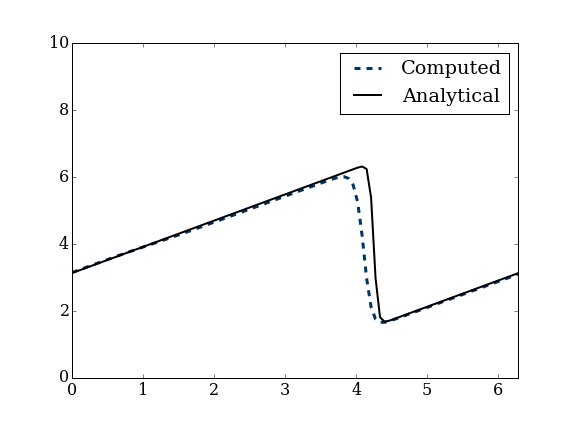
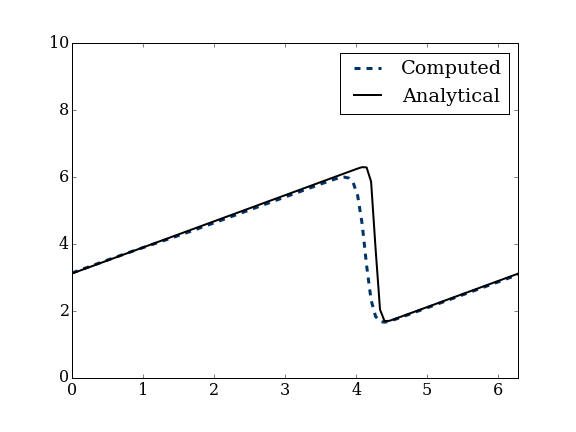
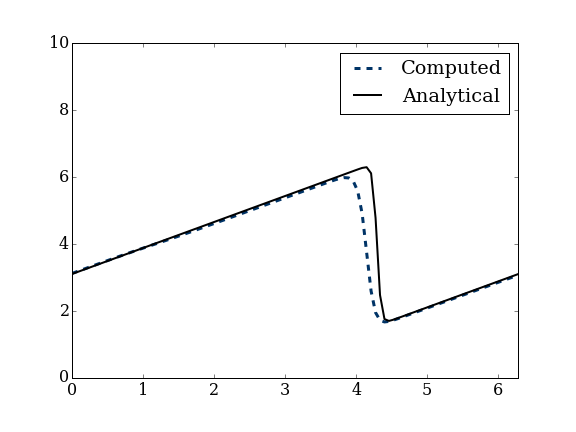
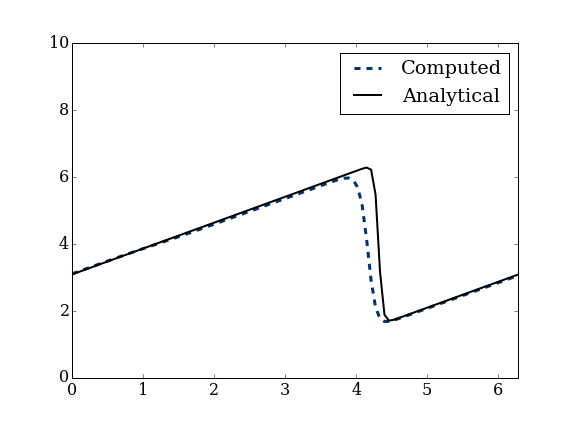
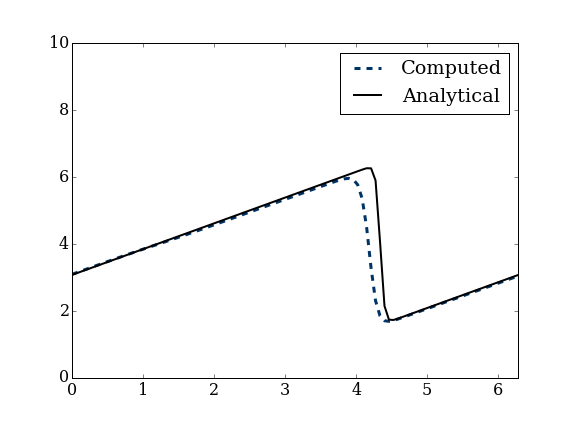
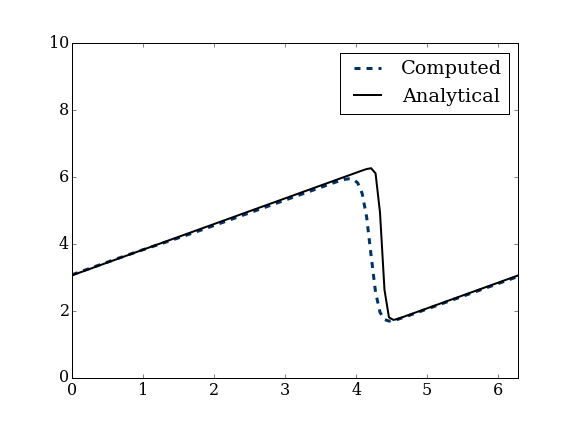
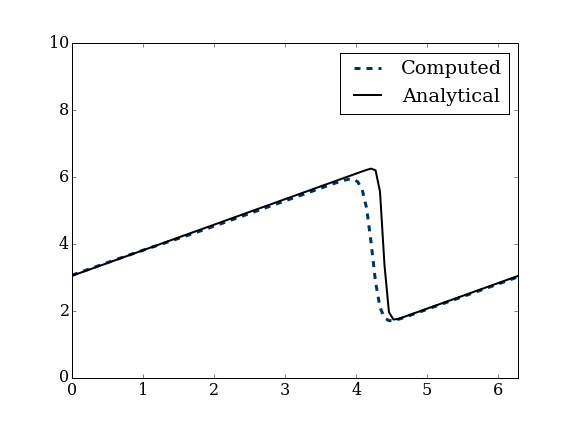
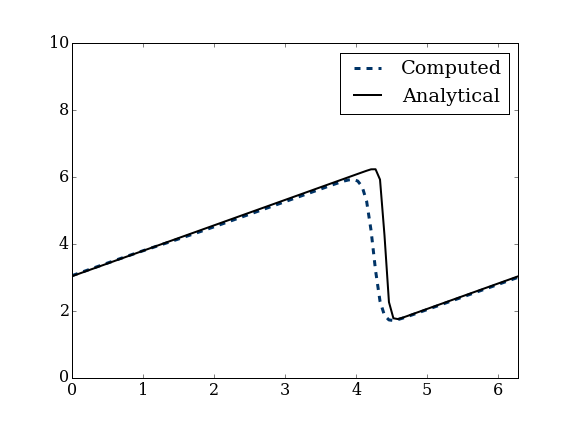
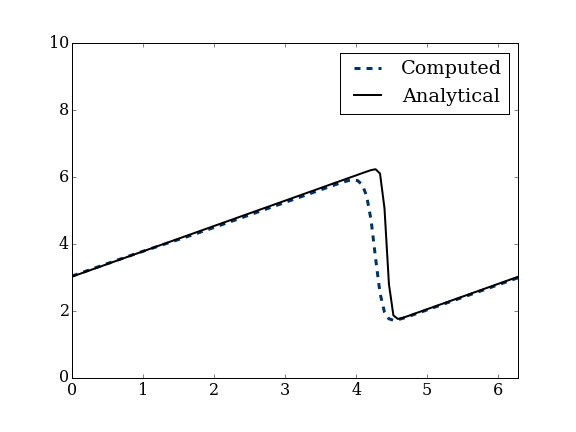
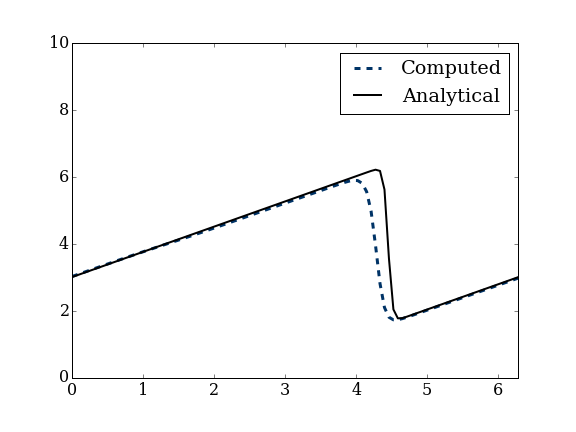
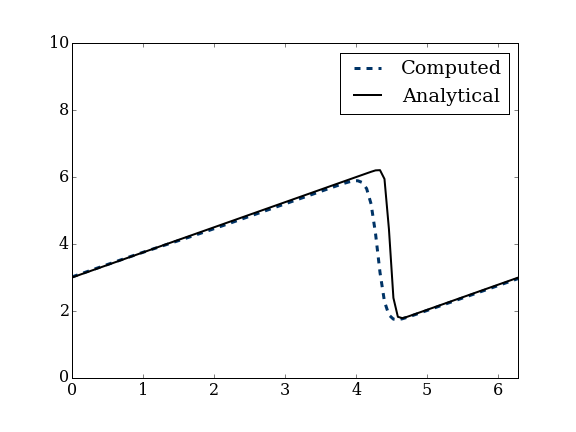
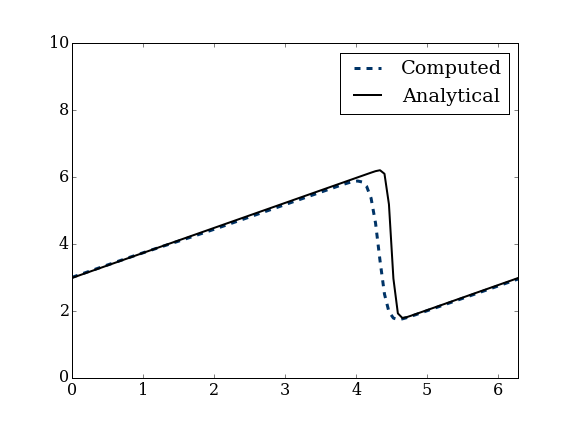
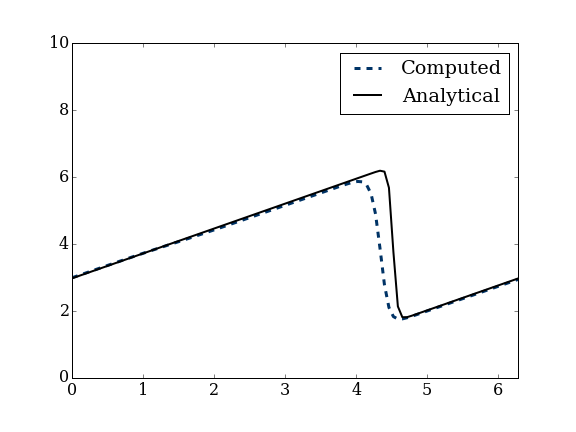
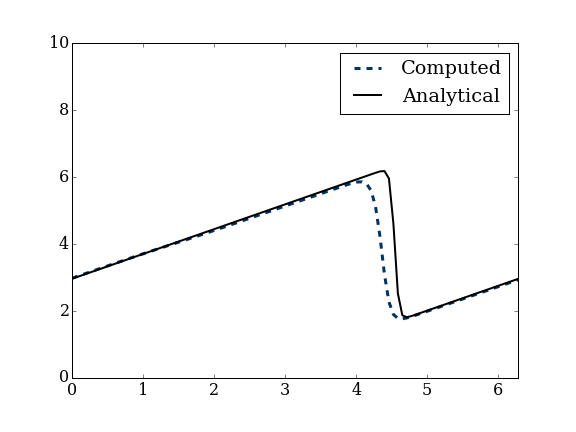
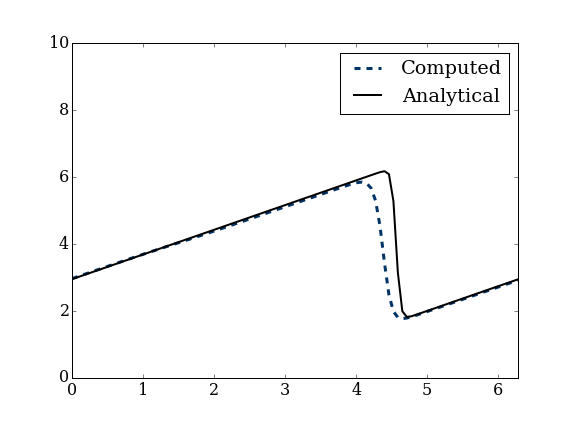
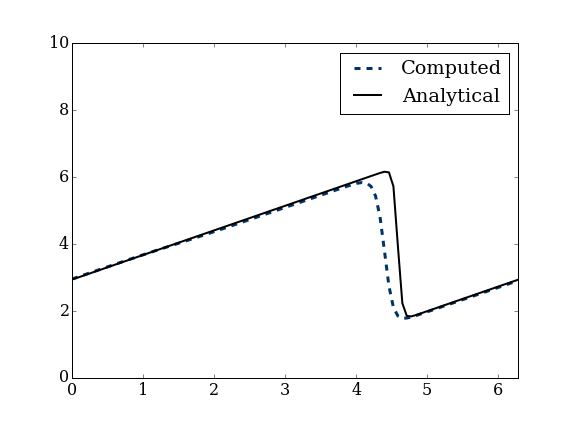
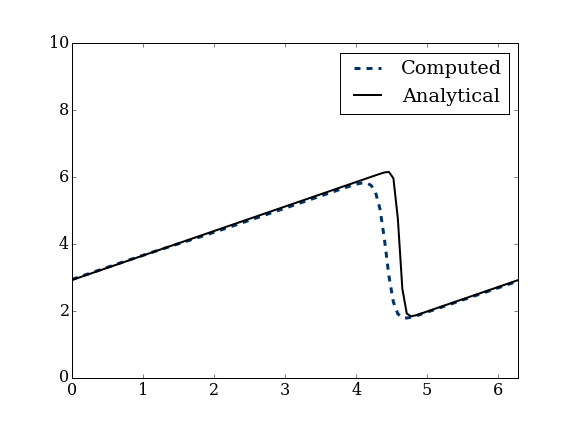
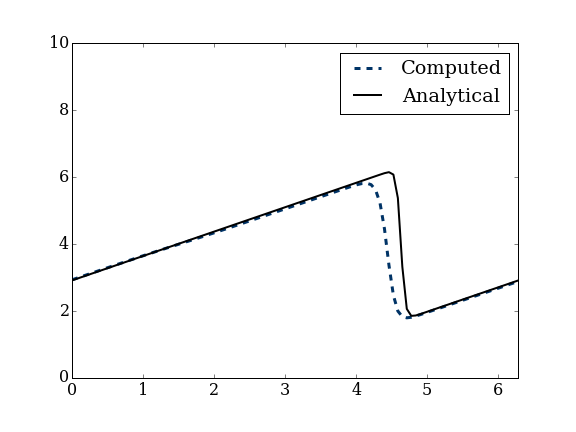
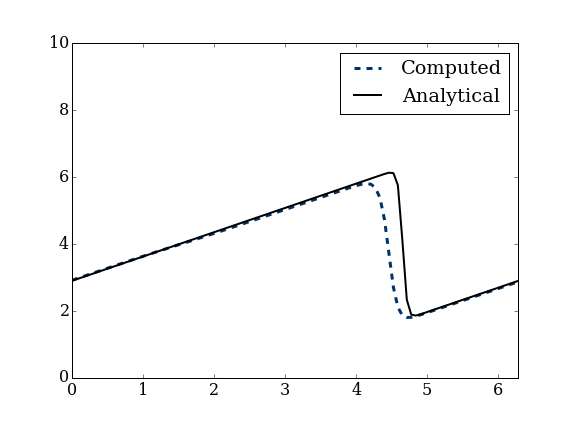
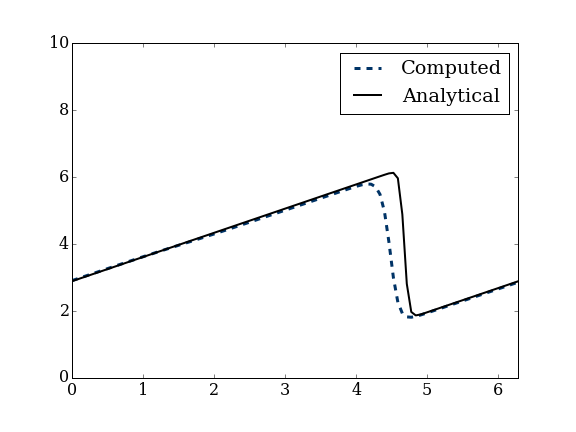
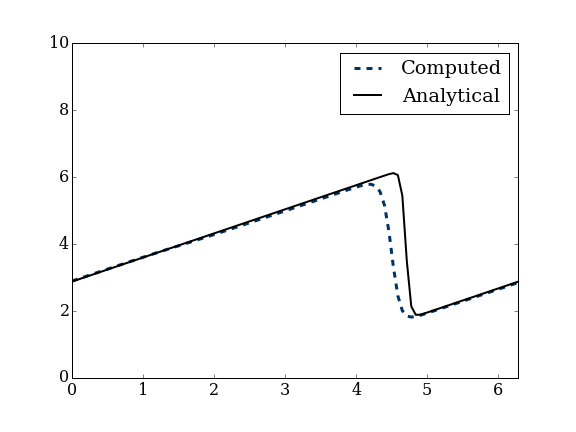
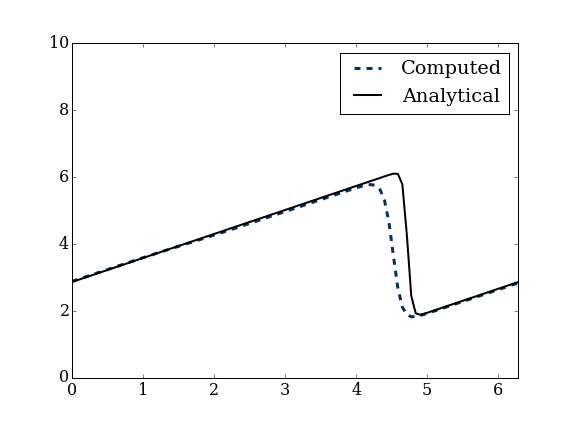
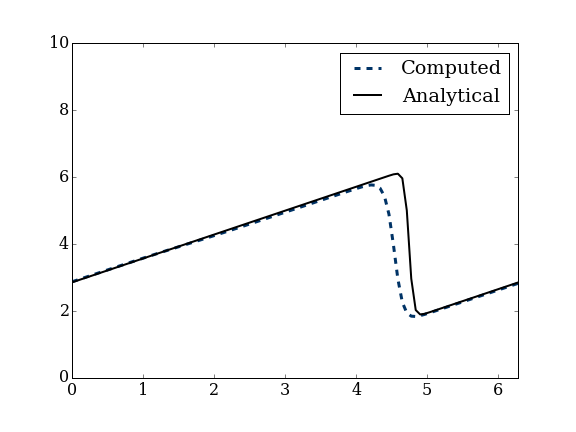
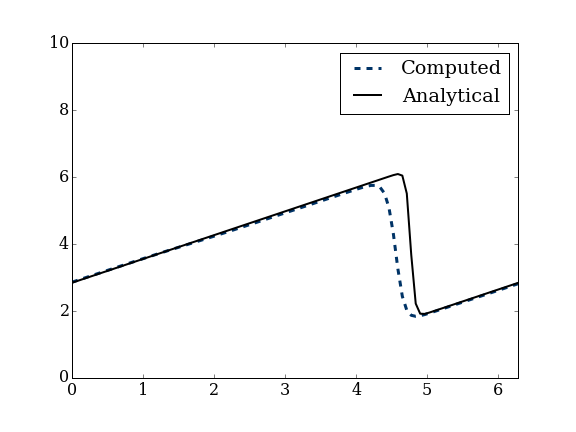
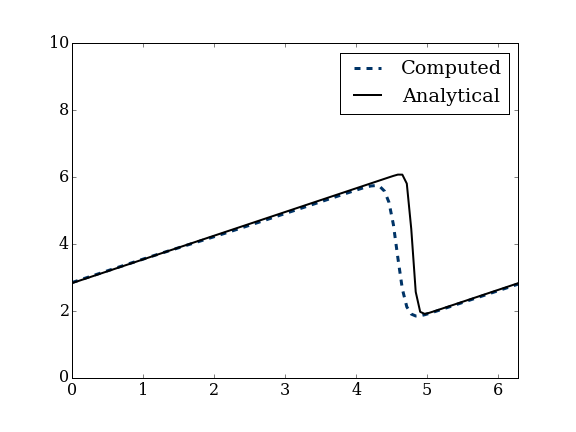
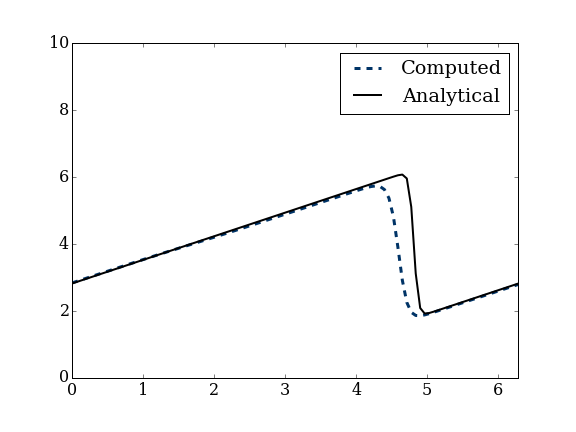
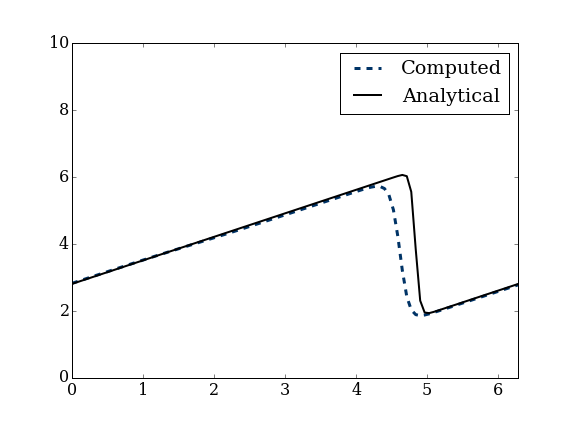
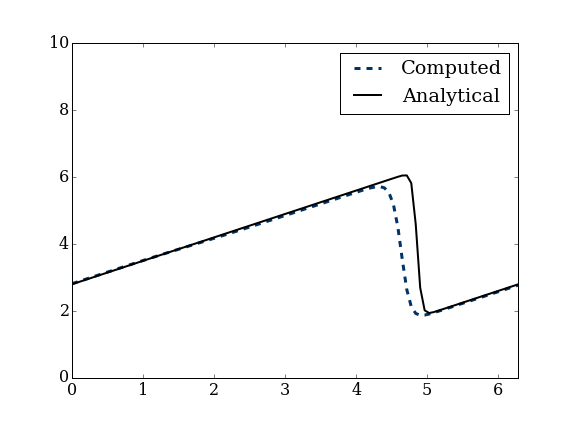
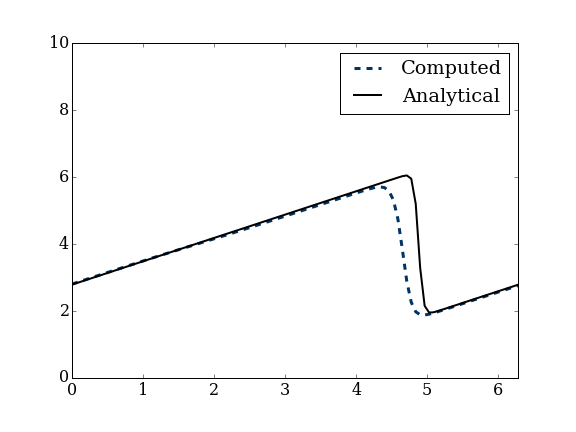
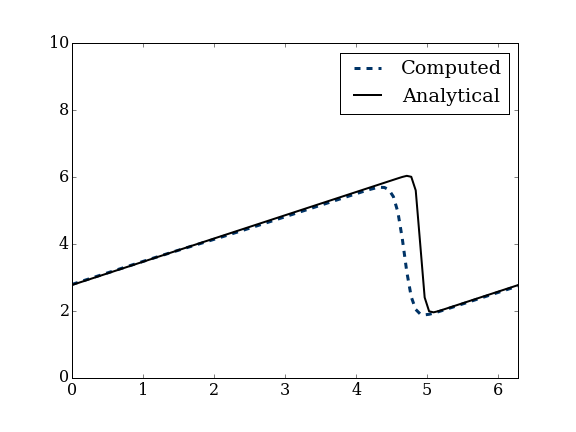
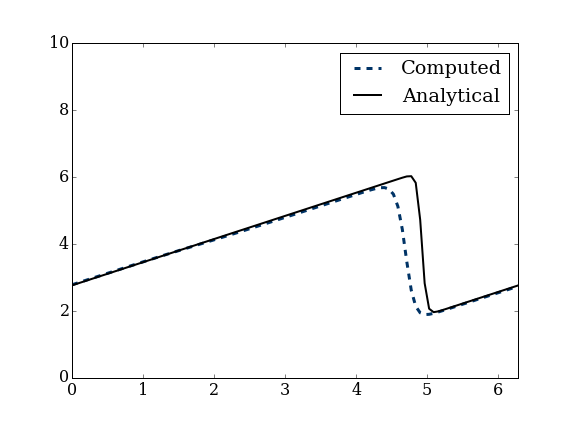
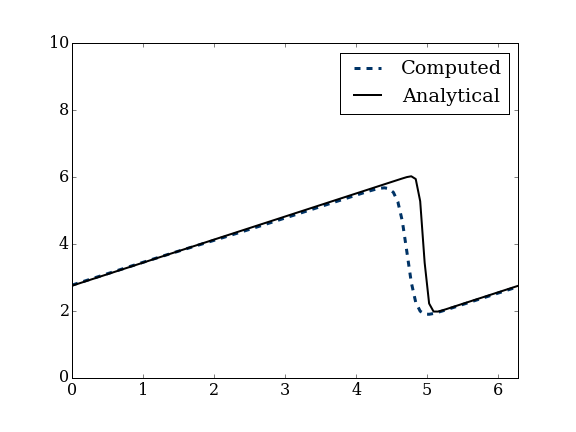
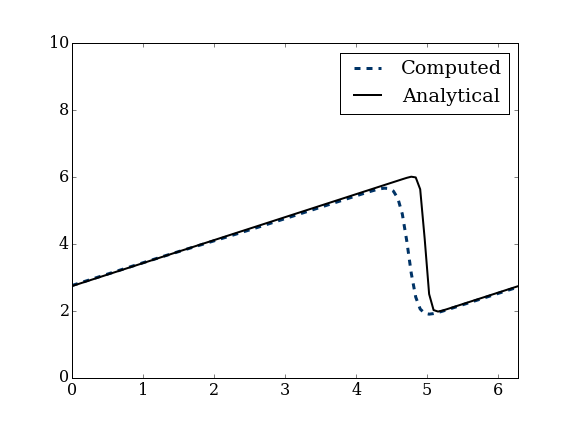
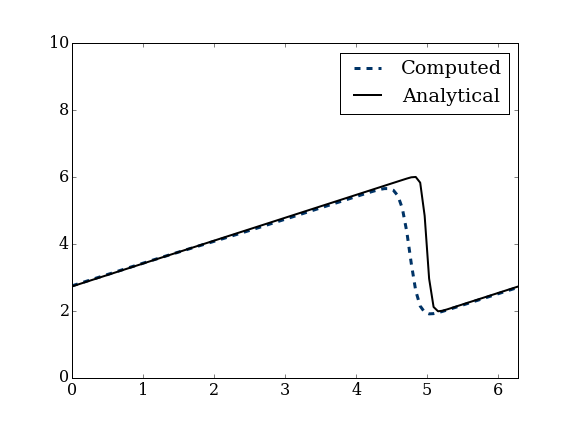
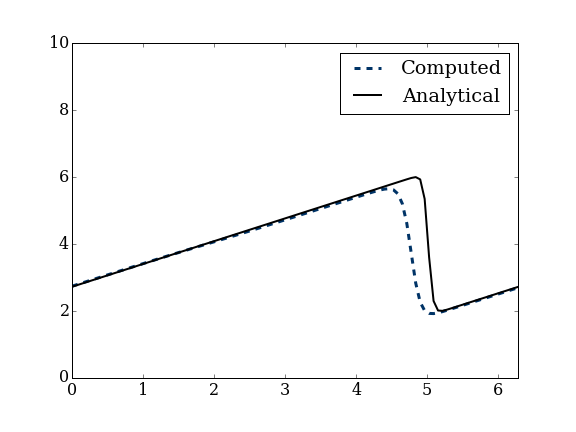
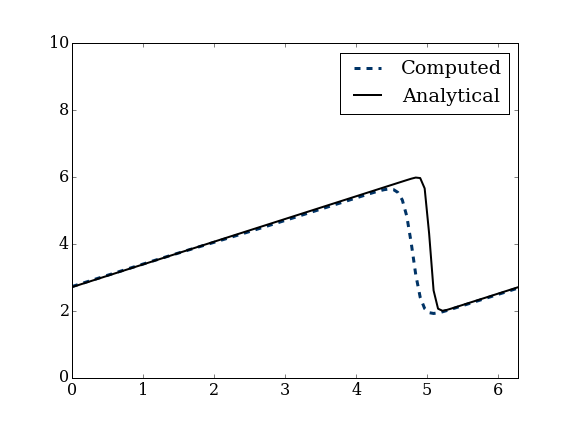
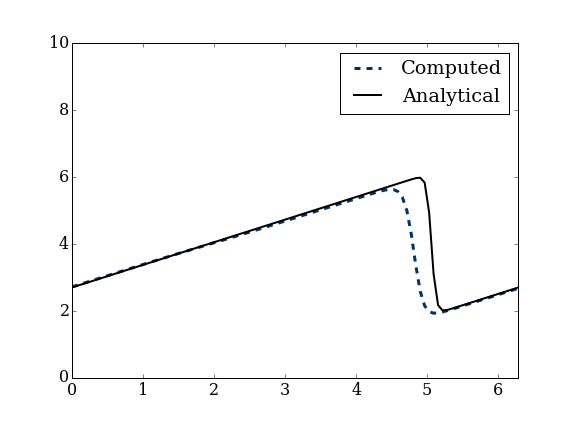
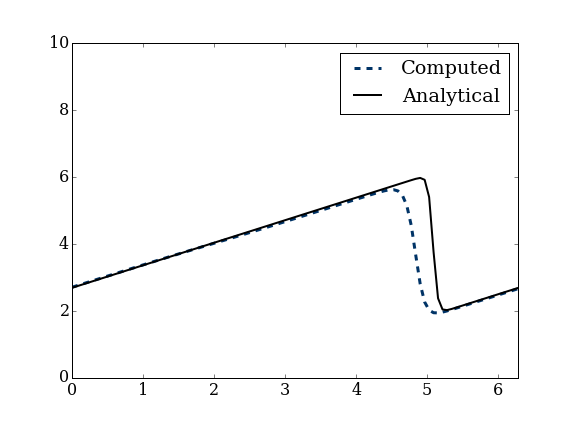
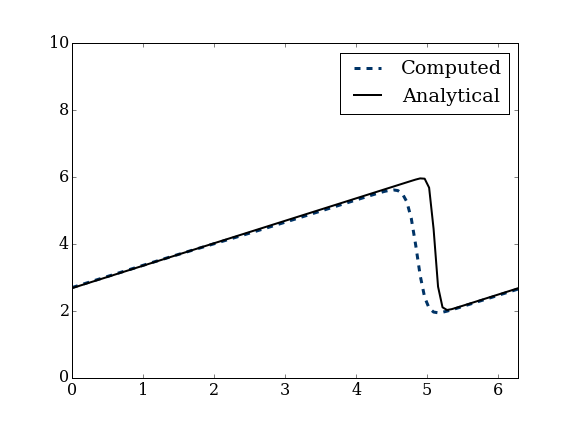
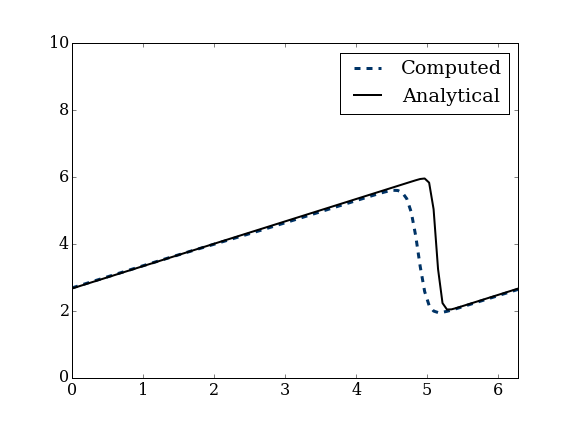
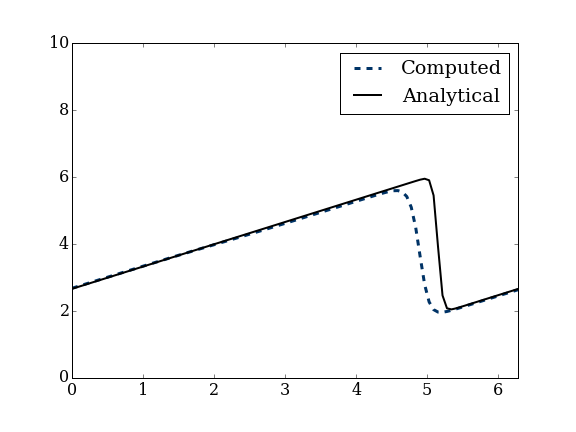
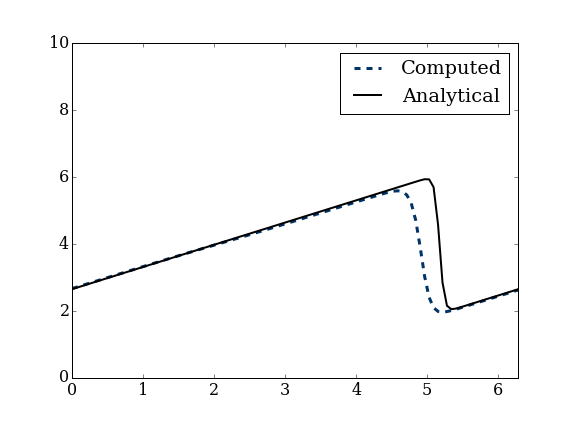
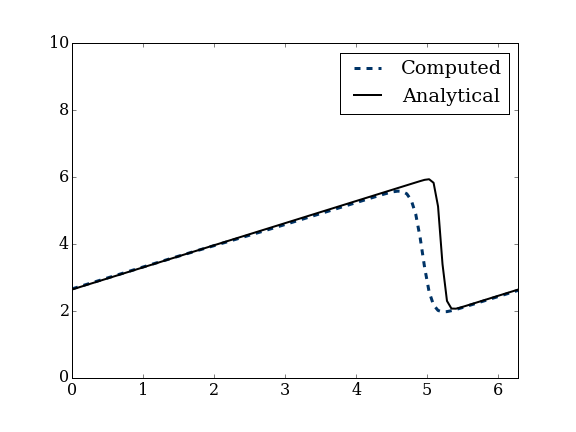
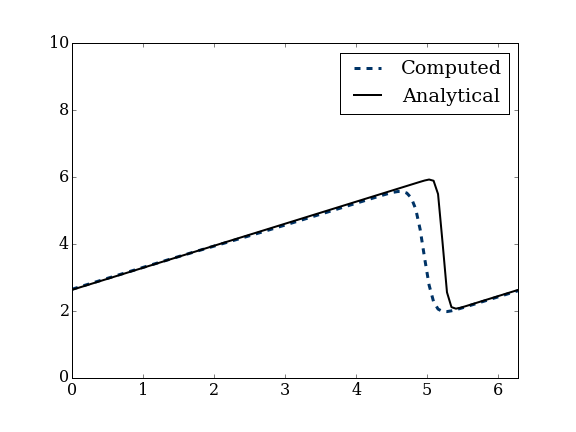
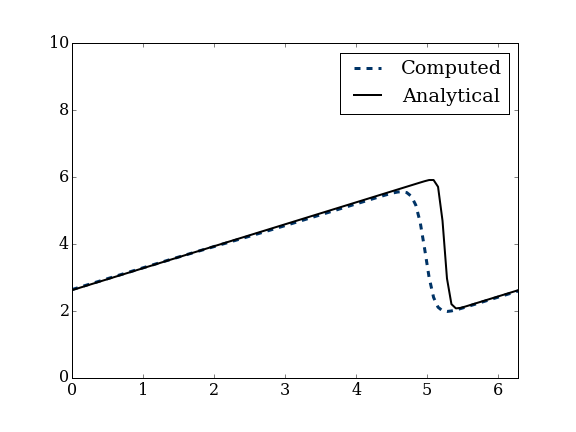
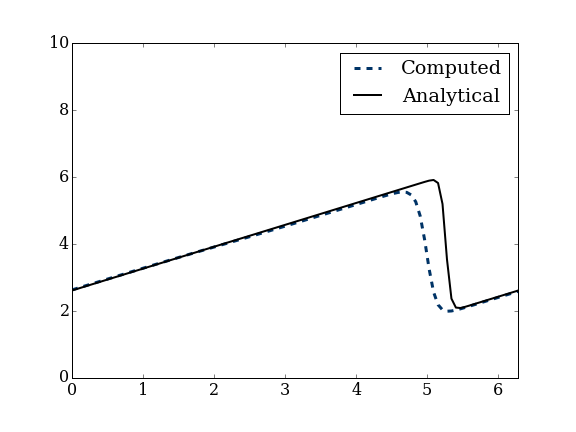
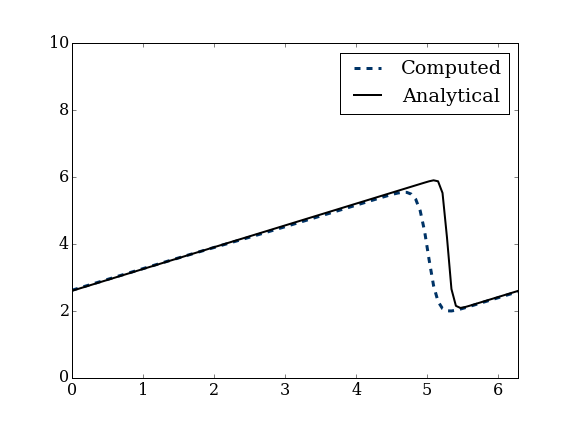
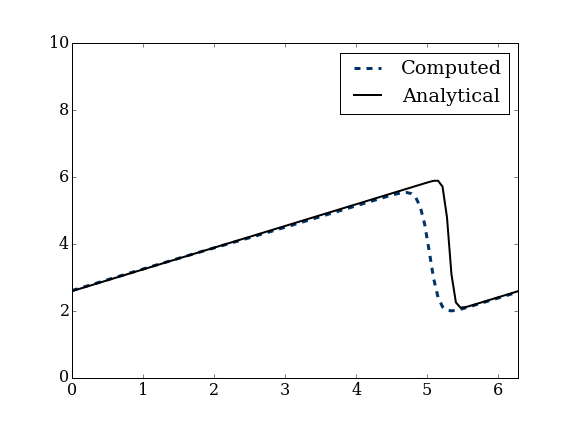
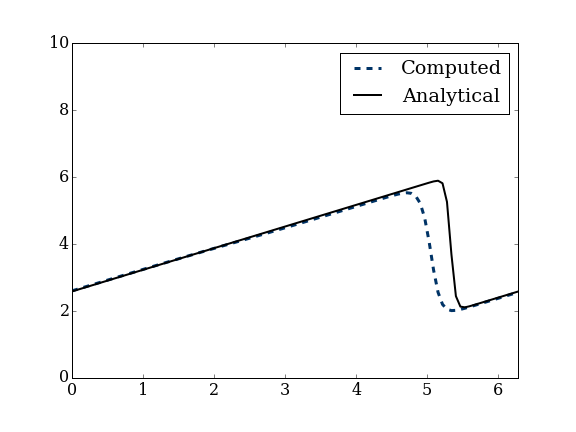
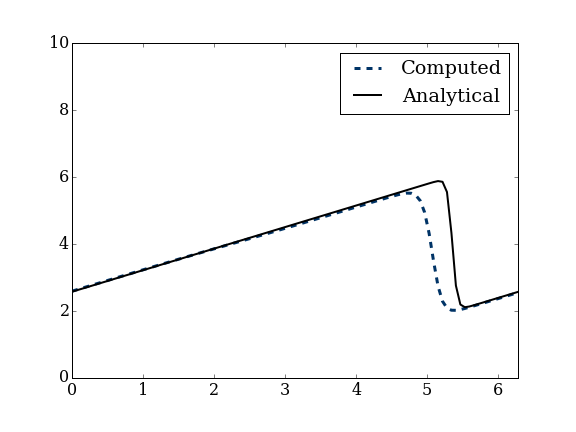
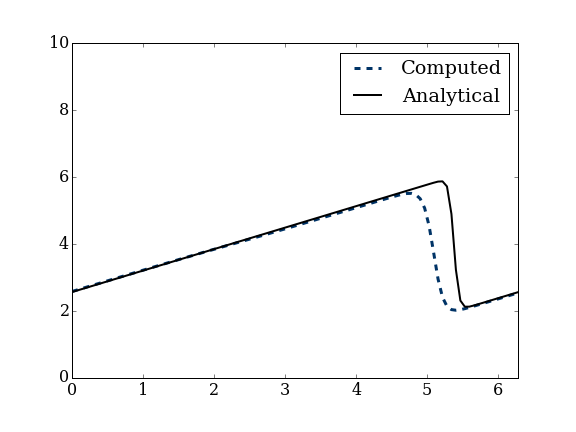

In [20]:
fig = pyplot.figure(figsize=(8,6))
ax = pyplot.axes(xlim=(0,2*numpy.pi), ylim=(0,10))
line = ax.plot([], [], color='#003366', ls='--', lw=3)[0]
line2 = ax.plot([], [], 'k-', lw=2)[0]
ax.legend(['Computed','Analytical'])

def burgers(n):
       
    un = u.copy()
        
    u[1:-1] = un[1:-1] - un[1:-1] * dt/dx * (un[1:-1] - un[:-2]) + nu*dt/dx**2*\
                    (un[2:] - 2*un[1:-1] + un[:-2])

    u[0] = un[0] - un[0] * dt/dx * (un[0] - un[-1]) + nu*dt/dx**2*\
                (un[1] - 2*un[0] + un[-1])
    u[-1] = un[-1] - un[-1] * dt/dx * (un[-1] - un[-2]) + nu*dt/dx**2*\
                (un[0]- 2*un[-1] + un[-2])
        
    u_analytical = numpy.asarray([u_lamb(n*dt, xi, nu) for xi in x])
    line.set_data(x,u)
    line2.set_data(x, u_analytical)
    

animation.FuncAnimation(fig, burgers,
                        frames=nt, interval=100)

## Array Operation Speed Increase

Coding up discretization schemes using array operations can be a bit of a pain.  It requires much more mental effort on the front-end than using two nested `for` loops.  So why do we do it?  Because it's fast.  Very, very fast.

Here's what the Burgers code looks like using two nested `for` loops.  It's easier to write out, plus we only have to add one "special" condition to implement the periodic boundaries.  

At the top of the cell, you'll see the decorator `%%timeit`.
This is called a "cell magic".  It runs the cell several times and returns the average execution time for the contained code.  

Let's see how long the nested `for` loops take to finish.

In [21]:
%%timeit

u = numpy.asarray([u_lamb(t, x0, nu) for x0 in x])

for n in range(nt):
    un = u.copy()
    
    for i in range(nx-1):
        u[i] = un[i] - un[i] * dt/dx *(un[i] - un[i-1]) + nu*dt/dx**2*\
                (un[i+1]-2*un[i]+un[i-1])
    
    u[-1] = un[-1] - un[-1] * dt/dx * (un[-1] - un[-2]) + nu*dt/dx**2*\
                (un[0]- 2*un[-1] + un[-2])
    

100 loops, best of 3: 14.3 ms per loop


Less than 50 milliseconds.  Not bad, really.  

Now let's look at the array operations code cell.  Notice that we haven't changed anything, except we've added the `%%timeit` magic and we're also resetting the array `u` to its initial conditions.  

This takes longer to code and we have to add two special conditions to take care of the periodic boundaries.  Was it worth it?

In [22]:
%%timeit

u = numpy.asarray([u_lamb(t, x0, nu) for x0 in x])

for n in range(nt):
    un = u.copy()
    
    u[1:-1] = un[1:-1] - un[1:-1] * dt/dx * (un[1:-1] - un[:-2]) + nu*dt/dx**2*\
                    (un[2:] - 2*un[1:-1] + un[:-2])

    u[0] = un[0] - un[0] * dt/dx * (un[0] - un[-1]) + nu*dt/dx**2*\
                (un[1] - 2*un[0] + un[-1])
    u[-1] = un[-1] - un[-1] * dt/dx * (un[-1] - un[-2]) + nu*dt/dx**2*\
                (un[0]- 2*un[-1] + un[-2])


1000 loops, best of 3: 1.5 ms per loop


Yes, it is absolutely worth it.  That's a nine-fold speed increase.  For this exercise, you probably won't miss the extra 40 milliseconds if you use the nested `for` loops, but what about a simulation that has to run through millions and millions of iterations?  Then that little extra effort at the beginning will definitely pay off.  

---

######The cell below loads the style of the notebook.

In [23]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())